In [1]:
#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [24]:
#%% Define file locations
WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_34/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_32/"   
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_30/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_28/"  
# WRF_DIRECTORY = "/pl/active/JKL_IDEAL/hurricanes/sst_26/"  
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01/"
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_ndg/"
WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_26_skipd01_skipCoLES_ndg/"
# WRF_DIRECTORY = "/rc_scratch/misa5952/hurricanes/sst_28_skipd01_skipCoLES_ndg/"

# Choose which domain to evaluate
domain = 'd02'

# Time series output for each restart
if domain=='d05':
    restarts = restarts[1]
elif domain=='d04':
#     restarts = restarts[0]
    restarts = 'timeSeries_d04'
elif domain=='d03':
    restarts = 'timeSeries_d03'
restarts = '.'


# Start time for simulations
startTime = np.datetime64('2000-01-01T00:00:00')
startTime_dom = np.datetime64('2000-01-06T10:00:00')

# Subsample data to reduce computational time and memory requirements
ss = 1


In [3]:
# Define eyewall radius based on 3D fields
if 'sst_26' in WRF_DIRECTORY:
    r_eye = 13805
    r_eye = 25000 #23361
    label = '26 C'
elif 'sst_28' in WRF_DIRECTORY:
    r_eye = 21300
    r_eye = 15138
    label = '28 C'
elif 'sst_30' in WRF_DIRECTORY:
    r_eye = 20333
    label = '30 C'
elif 'sst_32' in WRF_DIRECTORY:
    r_eye = 27055
    label = '32 C'
elif 'sst_34' in WRF_DIRECTORY:
    r_eye = 33638.915
    label = '34 C'

print('Eyewall radius at r = %f km' % (r_eye/1000))


Eyewall radius at r = 25.000000 km


In [7]:
#%% Extract data for domain size
# Find auxHist files for current domain
entries = os.listdir(WRF_DIRECTORY)
ofInterest = []
for i in np.arange(len(entries)):
    if domain in entries[i]:
        if 'auxH' in entries[i]:
            ofInterest = np.append(ofInterest,i)
ofInterest = ofInterest.astype('int')
rndmFromInterest = np.random.choice(ofInterest)

# entries = ["auxHist24_d03_2000-01-06_12:25:30","auxHist24_d02_2000-01-06_12:35:30"]
# rndmFromInterest = 0

# entries = ["auxHist24_d02_2000-01-06_11:31:30"]
# rndmFromInterest = 0

print(entries[rndmFromInterest])


# Extract data from auxHist file
ds = xr.open_dataset(WRF_DIRECTORY+str(entries[rndmFromInterest]),decode_times=False)
u = ds['U']
u = np.array(u[0,:,:,:])
v = ds['V']
v = np.array(v[0,:,:,:])
w = ds['W']
w = np.array(w[0,:,:,:])
# De-stagger wind speed
u_des = 0.5*(u[:,:,0:np.shape(u)[2]-1]+u[:,:,1:np.shape(u)[2]])
u = 0.0
v_des = 0.5*(v[:,0:np.shape(v)[1]-1,:]+v[:,1:np.shape(v)[1],:])
v = 0.0
# horizontal wind speed
uv = np.sqrt(np.array(u_des)**2 + np.array(v_des)**2)
u_des = 0.0
v_des = 0.0
# Time
Time_3d = ds['Times']
a = str(np.array(Time_3d)[0])
ttime_3d = np.datetime64(a[2:12] + str(' ')+ a[13:-1])
# Domain dimensions
dx = ds.DX
n_x = dx*np.arange(0,np.shape(uv)[2])
n_y = dx*np.arange(0,np.shape(uv)[1])

# Save some memory
uv = uv[0:10,:,:]
w = w[0:10,:,:]

ds.close()


auxHist24_d02_2000-01-06_10:22:30


In [12]:
# Time series locations
# Station locations
locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(2,3)) # [i,j]
name_locs = np.loadtxt(WRF_DIRECTORY +restarts+ '/tslist',skiprows=3,usecols=(1),dtype='U')

# Turbine specifications
D = 126 #240
z_hh = 90 #150
rated_ws = 11.4

locs = locs.astype('int')


In [100]:
#%% Radial distance from center of the hurricane (assume no translation)
# Center of the hurricane
center_x = np.mean(n_x)
center_y = np.mean(n_y)

# Radial distance
radial_dist = ((n_x[locs[:,0]] - center_x)**2 + (n_y[locs[:,1]] - center_y)**2)**0.5


In [172]:
#%% Radial locations to evaluate spinup
rad_dist_spctr = np.arange(0.5,2,0.2)*r_eye

# Find stations closer to radial locations 
i_stst_spctr = np.zeros_like(rad_dist_spctr)
for i in np.arange(len(rad_dist_spctr)):
    i_stst_spctr[i] = np.argmin(np.abs(radial_dist-rad_dist_spctr[i]))
i_stst_spctr = i_stst_spctr.astype('int')


tmp,ii = np.unique(i_stst_spctr,return_index=True)
i_stst_spctr = tmp
rad_dist_spctr = rad_dist_spctr[ii]


locs = locs[i_stst_spctr]
name_locs = name_locs[i_stst_spctr]
print(name_locs)



['d3021' 'd3150' 'd3154' 'd3137' 'd3246' 'd3019']


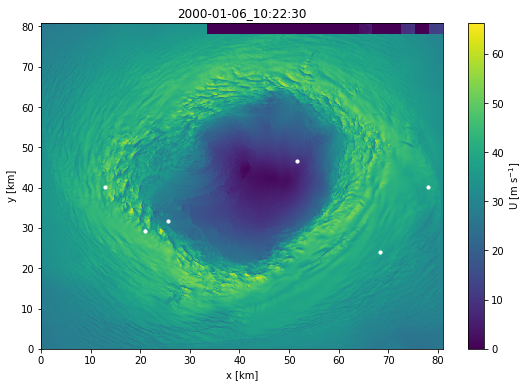

In [173]:
#%% Show relative locations of met tower in the domain
iz = 4

plt.figure(figsize=(9,6))
plt.title(str(Time_3d[0])[38:57])
im1 = plt.pcolormesh(n_x/1000,n_y/1000,uv[iz,:,:])
plt.scatter(n_x[locs[:,0]]/1000,n_y[locs[:,1]]/1000,s=10,color='white')
cbar = plt.colorbar(im1)
cbar.set_label("U [m s$^{-1}$]")
plt.xlabel('x [km]')
plt.ylabel('y [km]')
plt.show()
plt.close()


In [174]:
#%% Load timeseries data for subset of stations
# Time arrays
temp = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.UU',skiprows=1)
temp = temp[0:-200,:]
init_temp = temp[:,0]
time = temp[::ss,0]*(3600/1) # seconds since start of simulation
time_sinceRst = time - time[0] # seconds since initialization
TIME = startTime + time.astype('timedelta64[s]')

# Height array
GHT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[0]+'.'+domain+'.PH',skiprows=1)
hgt_agl_stg = GHT[::ss,1:] - GHT[0,1]
hgt_agl_stg = np.mean(hgt_agl_stg,axis=0)
hgt_agl = 0.5*(hgt_agl_stg[1:] + hgt_agl_stg[0:-1])
hgt_agl = np.append(hgt_agl,hgt_agl[-1] + (hgt_agl[-1] - hgt_agl[-2]))

# Initialize arrays [station,valForEachTimeStep,height]
U = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
V = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# W = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])
# theta = np.empty([len(locs),np.shape(time)[0],np.shape(temp)[1]-1])

# Extract data for each station
for i_s in np.arange(0,len(locs)):
    # Load data
    tempU = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.UU',skiprows=1)
    tempV = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.VV',skiprows=1)
#     tempW = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.WW',skiprows=1)
#     tempT = np.loadtxt(WRF_DIRECTORY+restarts+'/'+name_locs[i_s]+'.'+domain+'.TH',skiprows=1)
    # Save data
    U[i_s,:,:] = tempU[:np.shape(init_temp)[0]:ss,1:]
    V[i_s,:,:] = tempV[:np.shape(init_temp)[0]:ss,1:]
#     W[i_s,:,:] = tempW[:np.shape(init_temp)[0]:ss,1:]
#     theta[i_s,:,:] = tempT[:np.shape(init_temp)[0]:ss,1:]

    print('Done with %i out of %i' % (i_s,len(locs)-1))

# Release memory
tempU = 0.0
tempV = 0.0
# tempW = 0.0

print("Done extracting high-temporal resolution data")

Done with 0 out of 5
Done with 1 out of 5
Done with 2 out of 5
Done with 3 out of 5
Done with 4 out of 5
Done with 5 out of 5
Done extracting high-temporal resolution data


In [175]:
#%% Calculate horizontal wind speed and wind direction using time series output
# Calculate horizontal wind speed
UV = np.sqrt(U**2 + V**2)

# Calculate horizontal wind direction
wDir = np.zeros(np.shape(U))

for i_s in np.arange(np.shape(locs)[0]):
    for iz in np.arange(len(hgt_agl)):
        uu = np.zeros_like(U[i_s,:,iz]) + U[i_s,:,iz]
        vv = np.zeros_like(V[i_s,:,iz]) + V[i_s,:,iz]
#         vv[vv==0] = 0.1
#         wDir[i_s,:,iz] = np.arctan(uu/vv)*180/np.pi
        wDir[i_s,:,iz] = np.arctan2(vv,uu)*180/np.pi
        
# Wind direction in engineering coordinates (from [1,0] vector )
wDir[wDir<0] = (180 + wDir[wDir<0]) + 180

# Clear memory
U = 0.0
V = 0.0
uu = 0
vv = 0


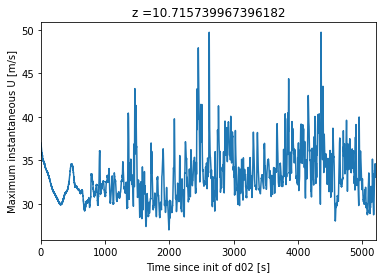

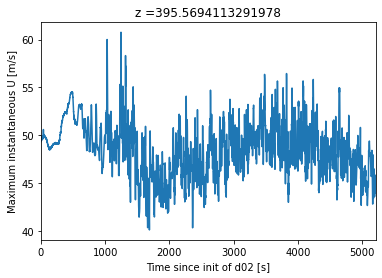

In [176]:
#%% Time series of maximum instantaneous wind speed at a given vertical level
col = plt.cm.viridis(np.linspace(0,1,len(locs)))

# Surface
iz = 0
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()


# Boundary layer
iz = -1
plt.figure()
plt.title('z ='+str(hgt_agl[iz]))
plt.plot(time_sinceRst,np.nanmax(np.abs(UV[:,:,iz]),axis=0))
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Maximum instantaneous U [m/s]')
plt.show()
plt.close()

In [177]:
#%% Define moving average function
def moving_average(x, n,mode):
    mv_avg = np.zeros(np.shape(x))
    temp = np.convolve(x, np.ones(n), mode) / n #full valid same
    if mode=='valid':
        mv_avg[0:np.shape(x)[0]-n+1] = temp
        # Fill edges with data
        mv_avg[-n:] = np.sum(x[-n:])/n
    elif mode=='same':
        mv_avg = temp
        mv_avg[0:n] = np.sum(x[0:n])/n
        mv_avg[-n:] = np.sum(x[-n:])/n
    
    return mv_avg

#%% Define moving median function
from scipy.ndimage import median_filter
def moving_median(x, n):
    return median_filter(x[x != 0], n)


In [178]:
#%% Mean time step in simulations
dt = np.mean(time[1:] - time[0:-1])

print(dt)


0.06018525387129179


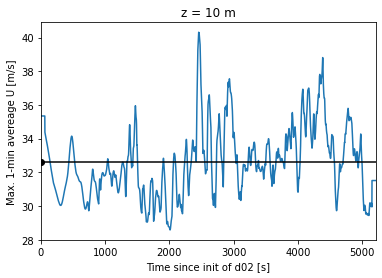

Tropical Storm with 32.620000 m/s average max. 1-min sustained winds


In [179]:
#%% Hurricane intensity
window_1m = 1*60 # [s]
n_window_1m = int(window_1m/dt)

avgUV_1m = np.zeros(np.shape(UV))
avgUV_1m = avgUV_1m[:,:,0]

for i_s in np.arange(np.shape(UV)[0]):
    avgUV_1m[i_s,:] = moving_average(UV[i_s,:,0],n_window_1m,'same')
    
# Mean intensity
mean_intensity = np.mean(np.max(np.abs(avgUV_1m),axis=0))

    
plt.figure()
plt.title('z = '+str(int(hgt_agl[0]))+" m")
# plt.plot(time_sinceRst,np.max(np.abs(UV[:,:,iz]),axis=0))
plt.plot(time_sinceRst,np.max(np.abs(avgUV_1m),axis=0))
plt.plot([0,time_sinceRst[-1]+1000],[mean_intensity,mean_intensity],'-o',color='black')
plt.xlim(time_sinceRst[0],time_sinceRst[-1])
plt.xlabel('Time since init of ' + str(domain)+' [s]')
plt.ylabel('Max. 1-min avereage U [m/s]')
plt.show()
plt.close()

# print(mean_intensity)

## Intensity of storm
thres_Cat1 = 33
thres_Cat2 = 43
thres_Cat3 = 50
thres_Cat4 = 58
thres_Cat5 = 70


if mean_intensity < thres_Cat1:
    print("Tropical Storm with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat1) & (mean_intensity < thres_Cat2):
    print("Category-1 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat2) & (mean_intensity < thres_Cat3):
    print("Category-2 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat3) & (mean_intensity < thres_Cat4):
    print("Category-3 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif (mean_intensity >= thres_Cat4) & (mean_intensity < thres_Cat5):
    print("Category-4 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))
elif mean_intensity>=thres_Cat5:
    print("Category-5 Hurricane with %f m/s average max. 1-min sustained winds" % np.round(mean_intensity,2))

In [180]:
# Time window for mean and perturbation quantities
window_avg = 10*60 # [s]
n_window_avg= int(window_avg/dt)

In [181]:
#%% Chose heights for analysis
z_spctr = np.array([10,100,350])
i_z_spctr = np.zeros_like(z_spctr)
for i in np.arange(len(z_spctr)):
    i_z_spctr[i] = np.argmin(np.abs(hgt_agl-z_spctr[i]))
i_z_spctr = i_z_spctr.astype('int')


In [213]:
#%% Get spectra for heights of interest
# Initialize arrays
avgUV_spctr = np.zeros([len(i_stst_spctr),np.shape(UV)[1],len(i_z_spctr)])
pertUV_spctr = np.zeros([len(i_stst_spctr),np.shape(UV)[1],len(i_z_spctr)])

# Calcluate mean and perturbation quantities
for i_s in np.arange(len(i_stst_spctr)): # station
    for iz in np.arange(len(i_z_spctr)): # height
        avgUV_spctr[i_s,:,iz] = moving_average(UV[i_s,:,i_z_spctr[iz]],n_window_avg,'same')
        pertUV_spctr[i_s,:,iz] = UV[i_s,:,i_z_spctr[iz]] - avgUV_spctr[i_s,:,iz]
pertUV_spctr = signal.detrend(pertUV_spctr,axis=1)

# Calculate turbulence spectra for each time window
n_window_spctr = int(1*n_window_avg)
num_batches = int(np.floor(np.shape(UV)[1]/n_window_spctr))
ff,P_temp = signal.welch(pertUV_spctr[-1,0:n_window_spctr,-1], fs=1/dt,window='hanning',nperseg=n_window_avg,scaling='spectrum')
P_temp = 0.0
df = np.median(ff[1:] - ff[0:-1])
P_uv = np.zeros([len(i_stst_spctr),len(i_z_spctr),num_batches,len(ff)]) + np.nan
for i_batch in np.arange(np.shape(P_uv)[2]): # Time window
    for i_s in np.arange(len(i_stst_spctr)): # station
        for iz in np.arange(len(i_z_spctr)): # height 
            ff,P_uv[i_s,iz,i_batch,:] = signal.welch(pertUV_spctr[i_s,int(i_batch*n_window_spctr):int((i_batch+1)*n_window_spctr),iz], fs=1/dt,window='hanning',nperseg=n_window_avg,scaling='spectrum',average='mean')


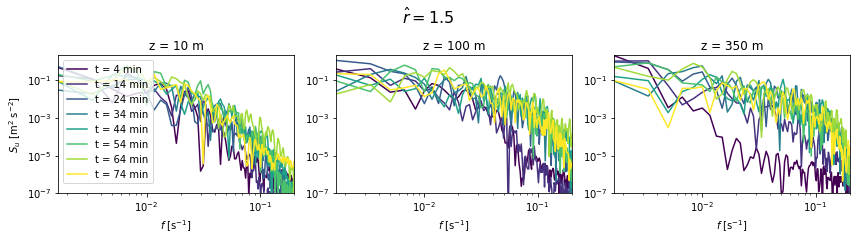

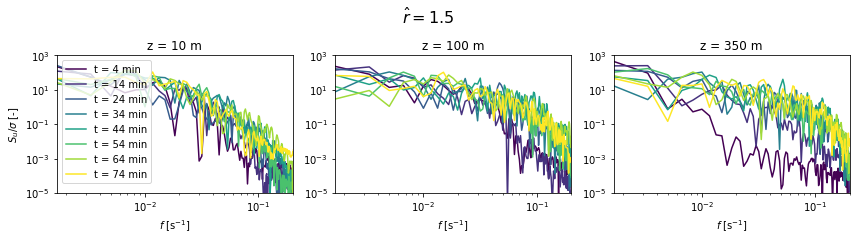

In [214]:
#%% Evaluate time required for spinup
i_s = -1

## Visualize spectra at all heights for one radial location in 10-min batches
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,num_batches))
for i_t in np.arange(num_batches): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        t_labl = n_window_spctr*dt*(i_t+0.5)/60
        axs[iz].loglog(ff,P_uv[i_s,iz,i_t,:],color=cols[i_t],label='t = ' + str(int(t_labl))+" min")
        if i_t==0:
            axs[iz].set_xlabel(r'$f$ [s$^{-1}$]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
#         axs[iz].set_xlim(ff[1],ff[-1])
#         axs[iz].set_ylim(1e-8,1e3)
        axs[iz].set_xlim(ff[1],2e-1)
        axs[iz].set_ylim(1e-7,2e0)
#         axs[iz].set_xlim(3e-1,3e0)
#         axs[iz].set_ylim(1e-8,1e3)
axs[0].legend()
axs[0].set_ylabel(r'$S_{u}$ [m$^2$ s$^{-2}$]') # (m/s)^2 / (1/s) -> density || (m/s)^2 -> spectrum
fig.suptitle(r'$\hat{r} = $'+str(np.round(radial_dist[i_s]/r_eye,2)),y=1.1,fontsize=16)
plt.tight_layout()
plt.show()

## Visualize normalized spectra at all heights for one radial location in 10-min batches
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,num_batches))
for i_t in np.arange(num_batches): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        t_labl = n_window_spctr*dt*(i_t+0.5)/60
        axs[iz].loglog(ff,P_uv[i_s,iz,i_t,:]/np.nansum(P_uv[i_s,iz,i_t,:]*df),color=cols[i_t],label='t = ' + str(int(t_labl))+" min")
        if i_t==0:
            axs[iz].set_xlabel(r'$f$ [s$^{-1}$]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
#         axs[iz].set_xlim(ff[1],ff[-1])
#         axs[iz].set_ylim(1e-8,1e3)
        axs[iz].set_xlim(ff[1],2e-1)
        axs[iz].set_ylim(1e-5,1e3)
#         axs[iz].set_xlim(3e-1,3e0)
#         axs[iz].set_ylim(1e-8,1e3)
axs[0].legend()
axs[0].set_ylabel(r'$S_{u}/\sigma$ [-]') # (m/s)^2 / (1/s) -> density || (m/s)^2 -> spectrum
# fig.legend(ncol=5,fontsize=7)#,bbox_to_anchor=(-0.28, 1.08, 1, .102))
fig.suptitle(r'$\hat{r} = $'+str(np.round(radial_dist[i_s]/r_eye,2)),y=1.1,fontsize=16)
plt.tight_layout()
plt.show()

In [215]:
#%% Time required for spinup
# Spinup time based on previous results 
t_spin_spctr = 1*n_window_spctr*dt # s

# Spinup time based on evolution of maximum wind speed
t_spin_maxUV = 33*60 # s

# Spinup time (max of both above)
t_spin_0 = np.max([t_spin_spctr,t_spin_maxUV])
print("%f minutes (%f seconds) for spinup" % (t_spin_0/60, t_spin_0))

33.000000 minutes (1980.000000 seconds) for spinup


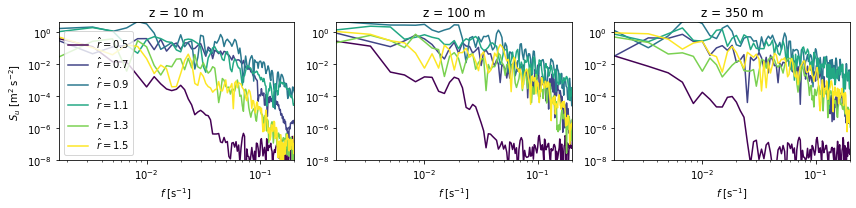

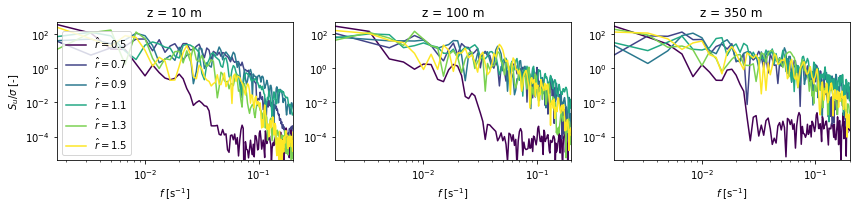

In [216]:
#%% Evaluate spatial extent required for spinup

i_t = 2

# Visualize spectra
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,len(rad_dist_spctr)))
for i_s in np.arange(len(rad_dist_spctr)): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        axs[iz].loglog(ff,P_uv[i_s,iz,i_t,:],color=cols[i_s],label=r'$\hat{r} = $'+str(np.round(rad_dist_spctr[i_s]/r_eye,2)))
        if i_s==0:
            axs[iz].set_xlabel(r'$f$ [s$^{-1}$]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
        axs[iz].set_xlim(ff[1],ff[-1])
        axs[iz].set_xlim(ff[1],2e-1)
        axs[iz].set_ylim(1e-8,4e0)
axs[0].legend()
axs[0].set_ylabel(r'$S_{u}$ [m$^2$ s$^{-2}$]') # (m/s)^2 / (1/s)
plt.tight_layout()
plt.show()


# Visualize normalized spectra
fig,axs = plt.subplots(1,len(z_spctr),figsize=(12,3))#, layout='constrained')
cols = plt.cm.viridis(np.linspace(0,1,len(rad_dist_spctr)))
for i_s in np.arange(len(rad_dist_spctr)): # 
    for iz in np.arange(len(z_spctr)):
        # uv-spectra
        axs[iz].loglog(ff,P_uv[i_s,iz,i_t,:]/np.nansum(P_uv[i_s,iz,i_t,:]*df),color=cols[i_s],label=r'$\hat{r} = $'+str(np.round(rad_dist_spctr[i_s]/r_eye,2)))
        if i_s==0:
            axs[iz].set_xlabel(r'$f$ [s$^{-1}$]')
            axs[iz].set_title("z = "+str(z_spctr[iz])+" m")
        axs[iz].set_xlim(ff[1],2e-1)
        axs[iz].set_ylim(4e-6,5e2)
axs[0].legend()
axs[0].set_ylabel(r'$S_{u}/\sigma$ [-]') # (m/s)^2 / (1/s)
# fig.legend(ncol=5,fontsize=7)#,bbox_to_anchor=(-0.28, 1.08, 1, .102))
plt.tight_layout()
plt.show()

